# Model-based machine learning - Chapter 1 - A Murder Mystery

This notebook is based on the [Model-based machine learning - Chapter 1 - A Murder Mystery](http://mbmlbook.com/MurderMystery.html), this [presentation](https://mltrain.cc/wp-content/uploads/2018/02/MLTrain@UAI_-Introduction-to-Pyro.pdf), and the [forum thread](https://forum.pyro.ai/t/importance-sampling-and-empirical-margin/627) using [Pyro](http://pyro.ai) and [PyTorch](https://pytorch.org).<br>

## Probabilities

**Murderer**<br>
P(murderer=Grey) = 0.3<br>
P(murderer=Auburn) = 0.7<br>

**Weapons**<br>
P(weapon=revolver|murderer=Grey) = 0.9<br>
P(weapon=dagger|murderer=Grey) = 0.1<br>

P(weapon=revolver|murderer=Auburn) = 0.2<br>
P(weapon=dagger|murderer=Auburn) = 0.8<br>

**Hair**<br>
P(weapon=True|murderer=Grey) = 0.5<br>
P(weapon=True|murderer=Auburn) = 0.05<br>

## Imports

In [1]:
import torch
import pyro
import pyro.infer

In [2]:
# prin pyro version
pyro.__version__

'0.3.0'

In [3]:
# check pyro version starts with '0.3.0'
assert pyro.__version__.startswith('0.3.0')

In [4]:
# enable validation while you are learning or debugging (http://pyro.ai/examples/tensor_shapes.html)
pyro.enable_validation(True)

In [5]:
# set random seed for reproducability
pyro.set_rng_seed(0)

## Basic model

In [6]:
def murder_basic():
    
    ## Murderer
    # Auburn = 1
    # Grey = 0
    
    # probability P(murderer)
    murderer = pyro.sample('murderer', pyro.distributions.Bernoulli(0.7))
    
    
    ## weapons
    # revolver = 1
    # dagger = 0
    
    if murderer == 0.0: # murderer = Grey
        p_weapon = 0.9
    else: # murderer = Auburn
        p_weapon = 0.2
    
    # conditional probability P(weapon|murderer)
    weapon = pyro.sample('weapon', pyro.distributions.Bernoulli(p_weapon))
    
    return murderer, weapon

In [7]:
# model test output
[murder_basic() for _ in range(10)]

[(tensor(1.), tensor(0.)),
 (tensor(1.), tensor(1.)),
 (tensor(1.), tensor(0.)),
 (tensor(1.), tensor(0.)),
 (tensor(1.), tensor(0.)),
 (tensor(1.), tensor(0.)),
 (tensor(1.), tensor(1.)),
 (tensor(1.), tensor(0.)),
 (tensor(1.), tensor(0.)),
 (tensor(1.), tensor(0.))]

## Condition on bullet found (weapon=revolver)

weapon = 1<br>
hair = 0 (False)

In [8]:
# Condition on weapon=revolver
conditioned_basic = pyro.condition(murder_basic, data={'weapon': torch.tensor(1.0)})

In [9]:
# check conditioning
conditioned_basic.msngr.data

{'weapon': tensor(1.)}

In [10]:
# P(murderer|weapon=revolver)
posterior_basic = pyro.infer.Importance(conditioned_basic, num_samples=1000)

In [11]:
# P(murderer)=∑(over weapon) P(murderer,weapon) ?
marginal_basic = pyro.infer.EmpiricalMarginal(posterior_basic.run(), sites='murderer')

In [12]:
# P(murderer=Auburn|weapon=revolver)
p_auburn_basic = marginal_basic.mean.item(); p_auburn_basic

0.34146350622177124

In [13]:
# P(murderer=Grey|weapon=revolver)
p_grey_basic = 1-marginal_basic.mean.item(); p_grey_basic

0.6585364937782288

In [14]:
# standard deviation
stddev_p_basic = marginal_basic.stddev.item(); stddev_p_basic

0.4742005467414856

## Extended model

In [15]:
def murder_ext():
    
    ## Murderer
    # Auburn = 1
    # Grey = 0
    
    # probability P(murderer)
    murderer = pyro.sample('murderer', pyro.distributions.Bernoulli(0.7))
    
    
    ## weapons
    # revolver = 1
    # dagger = 0
    
    if murderer == 0.0: # murderer = Grey
        p_weapon = 0.9
    else: # murderer = Auburn
        p_weapon = 0.2
    
    # conditional probability P(weapon|murderer)
    weapon = pyro.sample('weapon', pyro.distributions.Bernoulli(p_weapon))
    
    
    ## Hair
    
    if murderer == 0.0: # murderer = Grey
        p_hair = 0.5
    else: # murderer = Auburn
        p_hair = 0.05
    
    # conditional probability P(hair=True|murderer)
    hair = pyro.sample('hair', pyro.distributions.Bernoulli(p_hair))
    
    
    return murderer, weapon, hair

In [16]:
# model test output
[murder_ext() for _ in range(10)]

[(tensor(0.), tensor(1.), tensor(1.)),
 (tensor(0.), tensor(1.), tensor(1.)),
 (tensor(1.), tensor(0.), tensor(0.)),
 (tensor(0.), tensor(1.), tensor(0.)),
 (tensor(1.), tensor(0.), tensor(0.)),
 (tensor(1.), tensor(1.), tensor(0.)),
 (tensor(1.), tensor(0.), tensor(0.)),
 (tensor(0.), tensor(1.), tensor(1.)),
 (tensor(0.), tensor(1.), tensor(0.)),
 (tensor(0.), tensor(1.), tensor(0.))]

## Condition on bullet and hair found (weapon=revolver, hair=True) 

weapon = 1<br>
hair = 1 (True)

In [17]:
# Condition on weapon=revolver and hair=True
conditioned_ext = pyro.condition(murder_ext, data={'weapon': torch.tensor(1.0), 'hair': torch.tensor(1.0)})

In [18]:
# check conditioning
conditioned_ext.msngr.data

{'weapon': tensor(1.), 'hair': tensor(1.)}

In [19]:
# P(murderer|weapon=revolver,hair=True)
posterior_ext = pyro.infer.Importance(conditioned_ext, num_samples=1000)

In [20]:
# P(murderer)=∑(over weapon and hair) P(murderer,weapon,hair) ?
marginal_ext = pyro.infer.EmpiricalMarginal(posterior_ext.run(), sites='murderer')

In [21]:
# P(murderer=Auburn|weapon=revolver,hair=True)
p_auburn_ext = marginal_ext.mean.item(); p_auburn_ext

0.04798119142651558

In [22]:
# P(murderer=Grey|weapon=revolver,hair=True)
p_grey_ext = 1-marginal_ext.mean.item(); p_grey_ext

0.9520188085734844

In [23]:
# standard deviation
stddev_p_ext = marginal_ext.stddev.item(); stddev_p_ext

0.2137264609336853

# Results

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
p_auburn_means = (0.70, round(p_auburn_basic, 2), round(p_auburn_ext, 2))
p_grey_means = (0.30, round(p_grey_basic, 2), round(p_grey_ext, 2))

In [26]:
#stddev = (0.0, stddev_p_basic, stddev_p_basic) # for the prior there is no information on the stddev!

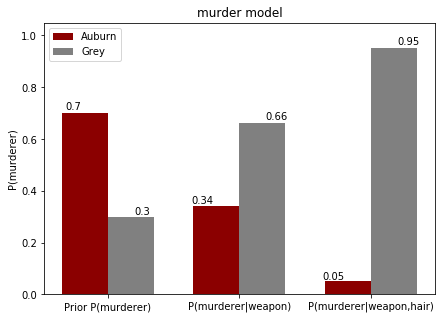

In [27]:
# based on https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html
ind = np.arange(len(p_auburn_means))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))
rects1 = ax.bar(ind - width/2, p_auburn_means, width, color='darkred', label='Auburn')
rects2 = ax.bar(ind + width/2, p_grey_means, width, color='gray', label='Grey')
#rects1 = ax.bar(ind - width/2, p_auburn_means, width, color='darkred', yerr=stddev, label='Auburn')
#rects2 = ax.bar(ind + width/2, p_grey_means, width, color='gray', yerr=stddev, label='Grey')

ax.set_title('murder model')
ax.set_ylabel('P(murderer)')
ax.set_ylim((0, 1.05))
ax.set_xticks(ind)
ax.set_xticklabels(('Prior P(murderer)', 'P(murderer|weapon)', 'P(murderer|weapon,hair)'))
ax.legend(loc=2)

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "right")

plt.show()